In [19]:
from wordcloud import WordCloud
from helpers import database, tokenizer
import pandas as pd

In [20]:
reviews = database.get_reviews(language="english")
reviews.head()

,id,recommendation_id,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,language,...,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck
0,215760124,None,76561199565605732,0,4,325,325,264,1768155336,english,...,1768151687,True,0,0,0.5,0,True,False,False,False
1,215756568,None,76561198026330868,39,10,4201,2559,4150,1768154369,english,...,1768148999,True,0,0,0.5,0,True,False,False,False
2,215744888,None,76561198066200885,221,44,5543,0,5543,1739371844,english,...,1768140031,True,0,0,0.5,0,True,False,False,False
3,215742083,None,76561198880718555,0,8,3239,2734,3147,1768155154,english,...,1768137616,True,0,0,0.5,0,True,False,False,False
4,215740976,None,76561199486130374,14,3,200,200,200,1768055486,english,...,1768136629,True,0,0,0.5,0,False,False,False,False


In [21]:
reviews.columns

Index(['id', 'recommendation_id', 'author_steamid', 'author_num_games_owned',
       'author_num_reviews', 'author_playtime_forever',
       'author_playtime_last_two_weeks', 'author_playtime_at_review',
       'author_last_played', 'language', 'review', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'primarily_steam_deck'],
      dtype='object')

In [27]:
from collections import defaultdict

word_counts = defaultdict(int)
word_positive = defaultdict(int)

ignored = ["game", "ff7", "rebirth", "final", "fantasy", "vii"]

for _, row in reviews.iterrows():
    tokens = set(tokenizer.tokenize(row["review"] or ""))
    for token in tokens:
        if token not in ignored:
            word_counts[token] += 1
            if row["voted_up"]:
                word_positive[token] += 1

records = []

for word, count in word_counts.items():
    positivity = word_positive[word] / count
    records.append({
        "word": word,
        "count": count,
        "positivity": positivity})

word_stats = pd.DataFrame(records).sort_values("count", ascending=False)
word_stats

,word,count,positivity
18,story,3129,0.739853
94,like,2663,0.668044
101,remake,2533,0.769049
4,good,2467,0.779489
158,games,2238,0.690795
...,...,...,...
23036,ainli,1,0.000000
23037,aftr,1,0.000000
23038,defalt,1,0.000000
23042,optimazashun,1,0.000000


In [28]:
max_words = 200
top_words = word_stats.head(max_words)
all_tokens_frequency = dict(zip(top_words["word"], top_words["count"]))
positivity_map = dict(zip(top_words["word"], top_words["positivity"]))

In [29]:
min_pos = top_words["positivity"].min()
max_pos = top_words["positivity"].max()

def normalize(value):
    if max_pos == min_pos:
        return 0.5
    return (value - min_pos) / (max_pos - min_pos)


In [30]:
import matplotlib.pyplot as plt

cmap = plt.colormaps["RdYlGn"]

def color_by_positivity(word, *args, **kwargs):
    raw_pos = positivity_map.get(word, 0.5)
    norm_pos = normalize(raw_pos)
    r, g, b, _ = cmap(norm_pos)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

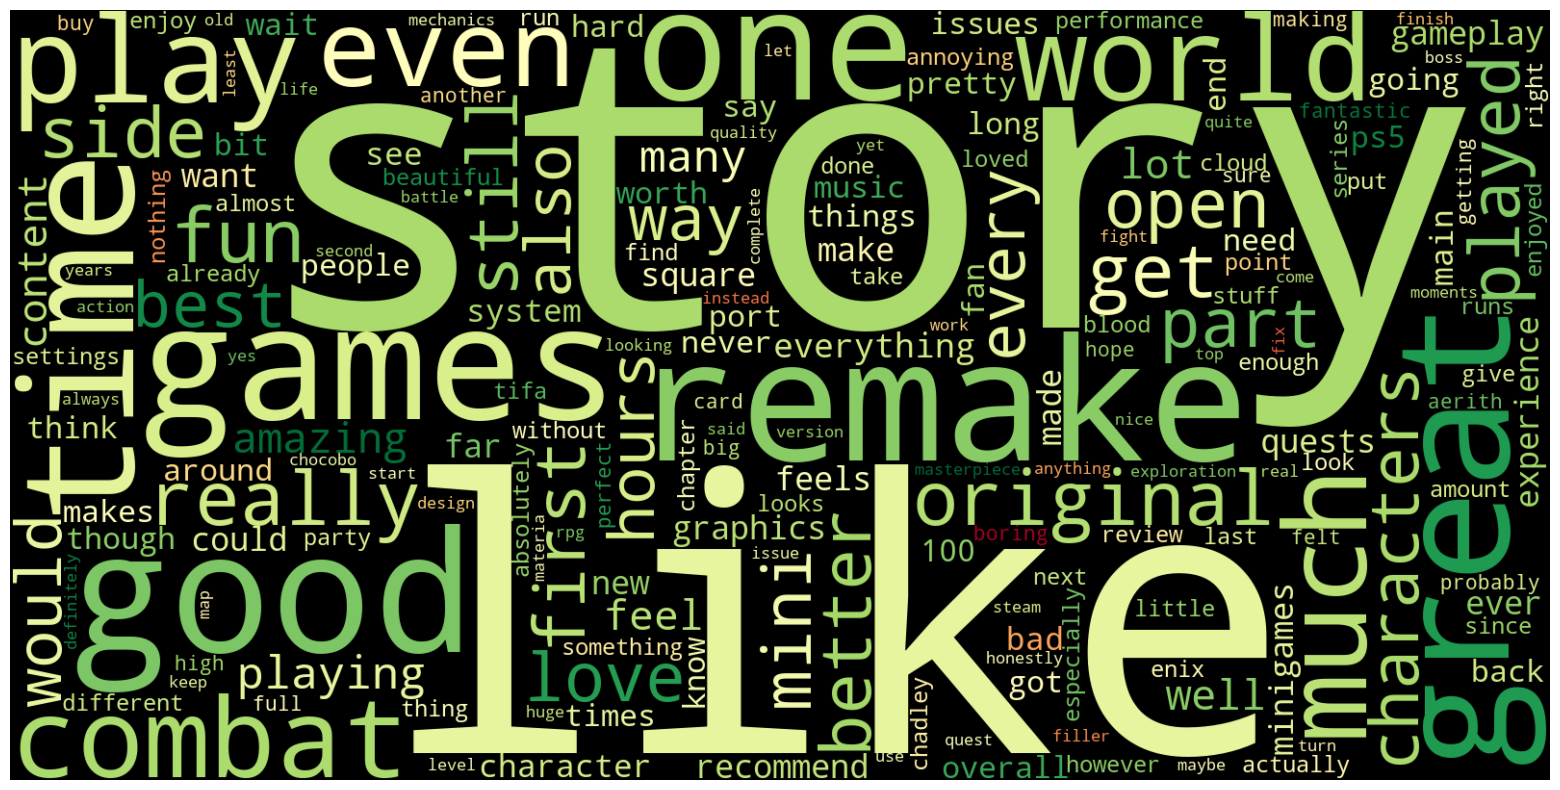

In [31]:
wc = WordCloud(
    width=1600,
    height=800,
    background_color="black",
    max_words=max_words
).generate_from_frequencies(all_tokens_frequency)
plt.figure(figsize=(20,10))
plt.imshow(wc.recolor(color_func=color_by_positivity, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.show()